## ETL - Proyecto Siniestros Viales de la ciudad de Buenos Aires, Argentina

El proceso de Extracción, Transformación y Carga (ETL) es esencial en el análisis de datos, permitiendo la preparación y el modelado de datos para su posterior análisis. En este proyecto, nos enfocaremos en un conjunto de datos específico relacionado con homicidios en siniestros viales en la Ciudad de Buenos Aires durante el período 2016-2021. A través del ETL, buscaremos comprender la naturaleza y las características de estos incidentes, identificando patrones significativos que puedan ayudar a las autoridades locales a tomar medidas efectivas para reducir la cantidad de víctimas fatales en siniestros viales.

Relacionamos las librearias que requerimos para realizar el proceso de transformación.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
import warnings 
warnings.filterwarnings('ignore')

In [3]:

# Ajustar la configuración de pandas para mostrar más filas y columnas, esto se realiza para evitar el trucamiento de salidas o muestras del metodo hide() en el editor .
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Declaración y definición de funciones de apoyo para el desarrollo del EDA

In [4]:
# Implemento una función que me muestre solamente las columnas que tengan valores nulos y su correspodiente porcentaje, que es de utilidad para el análisis

def InformacionNulos(df):
    # Calcular el número total de valores en cada columna
    total_values_per_column = df.shape[0]

    # Calcular el número de valores nulos en cada columna
    null_counts = df.isnull().sum()

    # Filtrar las columnas que tienen valores nulos
    columns_with_nulls = null_counts[null_counts > 0]

    # Calcular el porcentaje de valores nulos en cada columna
    null_percentage = (columns_with_nulls / total_values_per_column) * 100

    # Formatear el porcentaje con dos decimales y el símbolo %
    null_percentage_formatted = null_percentage.map(lambda x: f'{x:.2f}%')

    # Crear un DataFrame con la información de interés
    null_info = pd.DataFrame({
        'Column': columns_with_nulls.index,
        'Null Count': columns_with_nulls.values,
        'Null Percentage': null_percentage_formatted.values
    })

    # Retorna las columnas con valores nulos, la cantidad de nulos y su porcentaje formateado
    return null_info

### Cargue de DataSet de la hoja HECHOS del archivo de excel

In [5]:
# Cargamos la hoja hecho del archivo homicidios
df_hechos = pd.read_excel('DataSet/homicidios.xlsx', sheet_name="HECHOS")
df_hechos.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


In [6]:
# Identificamos los nombres de las etiqutas del DataFrame df_hechos con sus respectivos tipos de datos
df_hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

In [7]:
# Revisión de valores en cada columna del dataframe
InformacionNulos(df_hechos)

,Column,Null Count,Null Percentage
0,Calle,1,0.14%
1,Altura,567,81.47%
2,Cruce,171,24.57%
3,Dirección Normalizada,8,1.15%


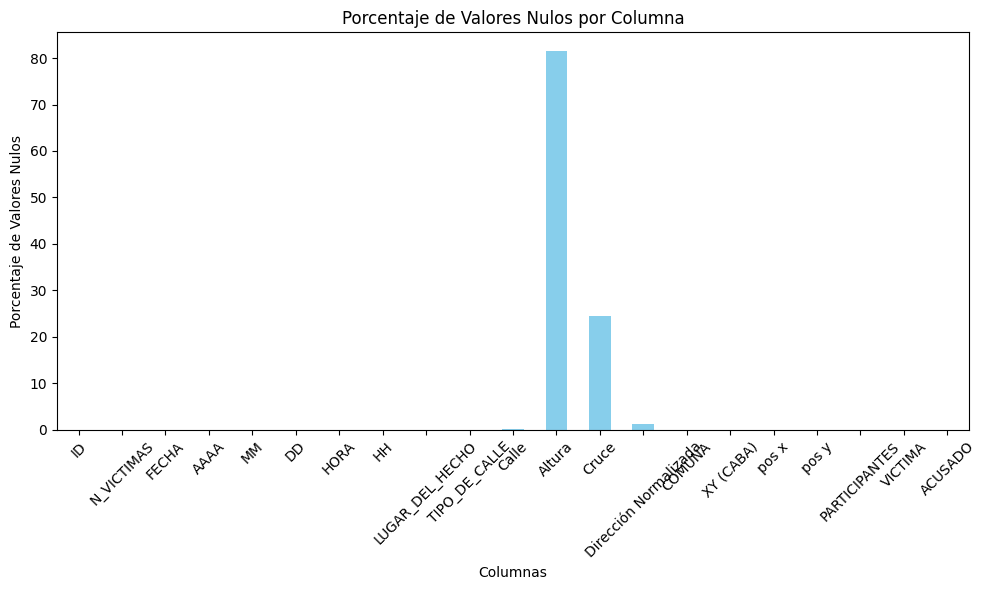

In [8]:
# Observar los valores nulos en el dataSet Hechos
# Mostrar que etiquetas contiene que porcentajes de valores nulos
null_counts = df_hechos.isnull().sum()
null_counts_percent = (null_counts / len(df_hechos)) * 100

plt.figure(figsize=(10, 6))
null_counts_percent.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Valores Nulos por Columna')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Valores Nulos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Revisión e la columna FECHA

In [9]:
# Mostrar el tipo de dato de la columna FECHA
tipo_dato_fecha = df_hechos['FECHA'].dtype
print(f"El tipo de dato de la columna FECHA es: {tipo_dato_fecha}")

El tipo de dato de la columna FECHA es: datetime64[ns]


In [10]:
# Contar la cantidad de valores nulos en la columna FECHA
num_valores_nulos = df_hechos['FECHA'].isnull().sum()
print("Cantidad de valores nulos en la columna 'FECHA':", num_valores_nulos)

Cantidad de valores nulos en la columna 'FECHA': 0


Revisión de la columna HORA

In [11]:
# Mostrar el tipo de dato de la columna HORA
tipo_dato_hora = df_hechos['HORA'].dtype
print(f"El tipo de dato de la columna HORA es: {tipo_dato_hora}")

El tipo de dato de la columna HORA es: object


In [12]:
df_hechos['HORA'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 696 entries, 0 to 695
Series name: HORA
Non-Null Count  Dtype 
--------------  ----- 
696 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB


In [13]:
# 1. Calcular la moda de la columna HORA
moda = df_hechos['HORA'].mode()[0]

# 2. Reemplazar valores nulos y los que tienen 'SD' por la moda
df_hechos['HORA'].replace('SD', moda, inplace=True)
df_hechos['HORA'].fillna(moda, inplace=True)

#Convertir a formato Hora
df_hechos['HORA'] = pd.to_datetime(df_hechos['HORA'], format='%H:%M:%S')

# Verificar el resultado
print(df_hechos['HORA'].head())

0   1900-01-01 04:00:00
1   1900-01-01 01:15:00
2   1900-01-01 07:00:00
3   1900-01-01 00:00:00
4   1900-01-01 05:20:00
Name: HORA, dtype: datetime64[ns]


In [14]:
# Contar la cantidad de valores nulos en la columna FECHA
num_valores_nulos = df_hechos['HORA'].isnull().sum()
print("Cantidad de valores nulos en la columna 'HORA':", num_valores_nulos)

Cantidad de valores nulos en la columna 'HORA': 0


In [15]:
# Contar la cantidad de valores NaN en la columna HORA
num_valores_nan = df_hechos['HORA'].isna().sum()

# Mostrar el resultado
print("Cantidad de valores NaN en la columna 'HORA':", num_valores_nan)

Cantidad de valores NaN en la columna 'HORA': 0


Analicemos la columna HH, que como indica el diccionario de datos en la franja horaria de tipo entero

In [16]:
# Mostrar el tipo de dato de la columna HH
tipo_dato_hh = df_hechos['HH'].dtype
print(f"El tipo de dato de la columna HH es: {tipo_dato_hh}")

El tipo de dato de la columna HH es: object


In [17]:
# Verificamos los valores
df_hechos['HH'].unique()

array([4, 1, 7, 0, 5, 18, 19, 15, 11, 22, 16, 9, 23, 6, 10, 17, 12, 8, 20,
       21, 14, 3, 2, 13, 'SD'], dtype=object)

Se reconoce la presencia de valores 'SD', se procede a reemplazar por la moda

In [18]:

# Calcular la moda de la columna HORA, excluyendo NaNs
hora_moda = df_hechos['HH'].mode().iloc[0]

# Reemplazar los valores NaN por la moda calculada
df_hechos['HH'].fillna(hora_moda, inplace=True)

# Convertir la columna HORA de vuelta a enteros (opcional, si necesitas el formato de enteros)
df_hechos['HH'] = df_hechos['HH'].replace(to_replace='.*SD.*', value=hora_moda, regex=True)

# Verificamos los valores
df_hechos['HH'].unique()


array([ 4,  1,  7,  0,  5, 18, 19, 15, 11, 22, 16,  9, 23,  6, 10, 17, 12,
        8, 20, 21, 14,  3,  2, 13], dtype=int64)

In [19]:
# Verificar si hay valores nulos en la columna 'HH'
hay_nulos = df_hechos['HH'].isnull().any()

# Mostrar el resultado
if hay_nulos:
    print("La columna 'HH' tiene valores nulos o NaN.")
else:
    print("La columna 'HH' no tiene valores nulos ni NaN.")

df_hechos['HH'].info()

La columna 'HH' no tiene valores nulos ni NaN.
<class 'pandas.core.series.Series'>
RangeIndex: 696 entries, 0 to 695
Series name: HH
Non-Null Count  Dtype
--------------  -----
696 non-null    int64
dtypes: int64(1)
memory usage: 5.6 KB


Analizamos la columna Calle

In [20]:
# Verificamos el registro donde la columna Calle es nulo
df_hechos[df_hechos['Calle'].isna()]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
119,2016-0151,1,2016-11-18,2016,11,18,1900-01-01 20:35:00,20,SD,CALLE,NaN,NaN,NaN,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


En cuanto a la columna Calle, solo se presenta un valor nulo en el Id 119, se decide mantener, ya que representa un hecho relacionado a un peatón que se presenta en fecha y hora, pero algunos datos son desconocidos, pero que puede influir en las visualizaciones de los datos.

In [21]:
# Reemplazamos el registro con ID= '2016-0151' en la column Calle el valor de "SD"
df_hechos.loc[df_hechos['ID'] == '2016-0151', 'Calle'] = 'SD'
# Verificamos que no tengan valores nulo en la columna Calle
df_hechos[df_hechos['Calle'].isna()]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO


Se observa que la columna "Altura" presentan una cantidad importante de valores nulos, 567 valores de 696 del total de registros, representado en 81.47%. Ante esta situación, se decide eliminar esta columna, considerando que no representa algún aporte para los hallazgos y conclusiones. 

In [22]:
# Se elimina la columna Altura del dataframe df_hechos
df_hechos.drop('Altura', axis=1, inplace=True)
df_hechos.head(1)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,1900-01-01 04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO


En la columna Cruce representa 24.57% con 171 valores nulos de 696, y aunque se denota que estos valores están hacen parte de algunos valores de la columna dirección normalizada, es importante mantener por que es posible, en futuro mostrar información de hechos específicamente relacionados a estos tipos de via "CRUCE", y determinar que tantos hechos de accidentalidad y homocidios se han presentado. Se plantea la necesidad de abordar estratégicamente estos datos faltantes, ya sea mediante técnicas de imputación o con una consideración especial, se decide que a estos valores faltantes asignarles el valor de "NO" indicano que el hecho no ocurrió en este tipo de vía CRUCE. 

In [23]:
# Se decide que los valores faltantes en la columna CRUCE, asignarles el valor de "NO" indicano que el hecho no ocurrió en este tipo de vía CRUCE. 
df_hechos['Cruce'].fillna('NO', inplace=True)


En cuanto a la columna Dirección Normalizada, solo se encuentra 8 registros de 696 del total de registros, representa el 1.15%, se sedice reemplazar estos valores nulos por el valor "SD" que indica no disponibles.

In [24]:
#  Reemplazar estos valores nulos por el valor "SD" que indica no disponibles en la columna Dirección Normalizada.
df_hechos['Dirección Normalizada'].fillna('SD', inplace=True)

Se identifica que en la columna XY (CABA), pos x y por y, se encuentran valores con Point (. .), y (.), indicando la falta de este valor, los mismo para las columnas posx y pos y con valores .

In [25]:
cruces = df_hechos.loc[df_hechos['XY (CABA)'] == 'Point (. .)','XY (CABA)']
print(len(cruces))

cruces = df_hechos.loc[df_hechos['pos y'] == '.','pos y']
print(len(cruces))

cruces = df_hechos.loc[df_hechos['pos x'] == '.','pos x']
print(len(cruces))


14
12
12


Son 14 registros que no presentan las coordenadas planas del hecho y también se ven 12 registros que tampoco presentan los datos 'Pos x' y 'Pos y'. Se imputarán 0 de modo tal que sirva para excluir el valor en el dashboard a realizar.

In [26]:
# Reemplazamos en la columna 'XY (CABA)' del DataFrame df_hechos los valores mal formateados 'Point (. .)' por 0.
# Esto estandariza los datos de ubicación y marca los registros con información de ubicación faltante o errónea.
df_hechos['XY (CABA)'] = df_hechos['XY (CABA)'].replace('Point (. .)', 0)
# Se reemplazan los valores faltantes por 0
df_hechos['pos x'] = df_hechos['pos x'].replace('.', 0)
df_hechos['pos y'] = df_hechos['pos y'].replace('.', 0)

In [27]:
# Convertir las columnas 'Pos x' y 'Pos y' a tipo float
df_hechos['pos x'] = df_hechos['pos x'].astype(float)
df_hechos['pos y'] = df_hechos['pos y'].astype(float)

Verificamos los cambios realizados

In [28]:
cruces = df_hechos.loc[df_hechos['XY (CABA)'] == 0,'XY (CABA)']
cruces

35     0
38     0
71     0
106    0
119    0
139    0
176    0
180    0
181    0
256    0
313    0
546    0
559    0
621    0
Name: XY (CABA), dtype: object

In [29]:
cruces = df_hechos.loc[df_hechos['pos x'] == 0,'pos x']
cruces

38     0.0
106    0.0
119    0.0
139    0.0
176    0.0
180    0.0
181    0.0
256    0.0
313    0.0
546    0.0
559    0.0
621    0.0
Name: pos x, dtype: float64

In [30]:
cruces = df_hechos.loc[df_hechos['pos y'] == 0,'pos y']
cruces

38     0.0
106    0.0
119    0.0
139    0.0
176    0.0
180    0.0
181    0.0
256    0.0
313    0.0
546    0.0
559    0.0
621    0.0
Name: pos y, dtype: float64

Se observan que los cambios realizados se ejecutaron correctamente.

Se analiza la columna Victima y acusado

In [31]:
# Valores úncos de la fila Victima
df_hechos['VICTIMA'].unique()

array(['MOTO', 'AUTO', 'PEATON', 'SD', 'CARGAS', 'BICICLETA', 'PASAJEROS',
       'MOVIL', 'OBJETO FIJO', 'PEATON_MOTO'], dtype=object)

Se detalla que se encuentran dos valores que no corresponden al diccionario de datos los cuales son 'OBJETO FIJO' y 'PEATON_MOTO'

In [32]:
# Relacionar los registros que contienen los valores 'OBJETO FIJO' y 'PEATON_MOTO'
df_hechos[df_hechos['VICTIMA'].isin(['OBJETO FIJO', 'PEATON_MOTO'])]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
230,2017-0108,2,2017-09-02,2017,9,2,1900-01-01 04:53:08,4,AV. GRAL. PAZ Y MACHAIN,GRAL PAZ,"PAZ, GRAL. AV.",MACHAIN,"PAZ, GRAL. AV. y MACHAIN",12,Point (97098.48468623 109019.96106626),-58.494911,-34.547956,AUTO-OBJETO FIJO,OBJETO FIJO,AUTO
583,2020-0063,2,2020-12-05,2020,12,5,1900-01-01 07:10:00,7,NUEVA YORK Y ALTA GRACIA,CALLE,NUEVA YORK,ALTA GRACIA,NUEVA YORK y ALTA GRACIA,11,Point (94080.62190808 102083.62453795),-58.527838,-34.610470,PEATON_MOTO-MOTO,PEATON_MOTO,MOTO


Se decide cambiar por el valor de 'OTRO'

In [33]:
# Se cambia por OTRO
df_hechos['VICTIMA'] = df_hechos['VICTIMA'].replace({'OBJETO FIJO':'OTRO', 'PEATON_MOTO':'OTRO'})

# Se verifican esos cambios
df_hechos[df_hechos['ID'].isin(['2017-0108', '2020-0063'])]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
230,2017-0108,2,2017-09-02,2017,9,2,1900-01-01 04:53:08,4,AV. GRAL. PAZ Y MACHAIN,GRAL PAZ,"PAZ, GRAL. AV.",MACHAIN,"PAZ, GRAL. AV. y MACHAIN",12,Point (97098.48468623 109019.96106626),-58.494911,-34.547956,AUTO-OBJETO FIJO,OTRO,AUTO
583,2020-0063,2,2020-12-05,2020,12,5,1900-01-01 07:10:00,7,NUEVA YORK Y ALTA GRACIA,CALLE,NUEVA YORK,ALTA GRACIA,NUEVA YORK y ALTA GRACIA,11,Point (94080.62190808 102083.62453795),-58.527838,-34.610470,PEATON_MOTO-MOTO,OTRO,MOTO


In [34]:
# Valores únicos de la fila Acusado
df_hechos['ACUSADO'].unique()


array(['AUTO', 'PASAJEROS', 'SD', 'OBJETO FIJO', 'CARGAS', 'MOTO',
       'MULTIPLE', 'OTRO', 'BICICLETA', 'TREN'], dtype=object)

Se observa que los datos no tinen complicación, y se conservar los valores.

### Cargue de DataSet de la hoja VICTIMAS del archivo de excel

In [70]:
# Cargamos la hoja victimas del archivo homicidios
df_victimas = pd.read_excel('DataSet/homicidios.xlsx', sheet_name="VICTIMAS")
df_victimas.head()

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00


In [36]:
# Identificamos los nombres de las etiqutas del DataFrame df_victimas con sus respectivos tipos de datos
df_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


Se detalla que en el dataframe victimas no se encuentran valores nulos

In [37]:
InformacionNulos(df_victimas)

,Column,Null Count,Null Percentage


Se confirma que que realmente no se cuentan con valores duplicados.

In [38]:
# Verificamos registros duplicados
df_victimas[df_victimas.duplicated()]

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO


No se encuentran registro duplicados

Continuamos analizando con la columna EDAD

In [39]:
# Cantidad de valores por tipo de dato en la columna 'EDAD'
tipos_datos = df_victimas['EDAD'].apply(type).value_counts()
print('Los tipos de datos son:')
print(tipos_datos)
print(f'Los datos {tipos_datos.index[1]} representan el {round((tipos_datos[1]/tipos_datos.sum()),2)}')

Los tipos de datos son:
EDAD
<class 'int'>    664
<class 'str'>     53
Name: count, dtype: int64
Los datos <class 'str'> representan el 0.07


In [40]:
# Revisar valores no numericos en la columna EDAD
df_victimas[df_victimas['EDAD'].apply(lambda x: isinstance(x, str))]

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
30,2016-0041,2016-03-29,2016,3,29,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,SD,2016-03-30 00:00:00
33,2016-0045,2016-04-11,2016,4,11,CONDUCTOR,MOTO,MASCULINO,SD,SD
35,2016-0048,2016-04-15,2016,4,15,PEATON,PEATON,FEMENINO,SD,SD
36,2016-0049,2016-04-17,2016,4,17,SD,SD,SD,SD,SD
39,2016-0052,2016-04-20,2016,4,20,SD,MOTO,SD,SD,SD
55,2016-0077,2016-06-13,2016,6,13,PEATON,PEATON,FEMENINO,SD,SD
63,2016-0085,2016-06-29,2016,6,29,SD,MOTO,MASCULINO,SD,SD
72,2016-0096,2016-07-25,2016,7,25,CONDUCTOR,MOTO,MASCULINO,SD,SD
89,2016-0115,2016-09-02,2016,9,2,SD,SD,MASCULINO,SD,SD
93,2016-0119,2016-09-04,2016,9,4,PASAJERO_ACOMPAÑANTE,SD,FEMENINO,SD,SD


Se observa que  664 registros de tipo entero y 53 registros de tipo string que representa el 7% de los registros. Vamos a revisar ese 7%

Para poder rellenar esos datos faltantes, se quiere imputar los mismos con el promedio de las edades de las victimas, pero teniendo en cuenta el 'SEXO'. Como se observa que esa variable también presenta faltantes de datos, primero se completan esos valores, teniendo en cuenta el valor mas frecuente entre las víctimas. Luegoimpitamos la edad segun el sexo.

Se analiza las columnas EDAD y SEXO que tienen valores SD

In [41]:
# Analizamos los valores de edad, y su tipo
tipos_datos = df_victimas['EDAD'].apply(type).value_counts()
print('Los tipos de datos son:')
print(tipos_datos)
print(f'Los datos {tipos_datos.index[1]} representan el {round((tipos_datos[1]/tipos_datos.sum()),2)}')

Los tipos de datos son:
EDAD
<class 'int'>    664
<class 'str'>     53
Name: count, dtype: int64
Los datos <class 'str'> representan el 0.07


Se observa que se encuentran valores 'SD' en SEXO, por lo que se decide imputar por la frecuencia de los valores del sexo

In [42]:
# Contar cuántos valores contienen el valor 'SD' en la columna SEXO
cruces = df_victimas.loc[df_victimas['SEXO'] == 'SD','SEXO']
num_registros = len(cruces)
print(num_registros)

6


Se encontraron 6 valores que corresponden al 0.8% del total 717 registros. Se realiza la actualización con la imputación de freciencia

In [43]:
# Verificamos los valores únicos de la columna SEXO
sexos = df_victimas['SEXO'].unique()
print(sexos)

['MASCULINO' 'FEMENINO' 'SD']


In [44]:
# Se reemplaza "SD" con NaN en la columna
df_victimas['SEXO'] = df_victimas['SEXO'].replace('SD', pd.NA)

# Verificamos los valores únicos de la columna SEXO
sexos = df_victimas['SEXO'].unique()
print(sexos)

['MASCULINO' 'FEMENINO' <NA>]


In [45]:
# Se calcula el valor más frecuente en la columna
valor_mas_frecuente = df_victimas['SEXO'].mode().iloc[0]
print(f"El valor más frecuente en la columna SEXO es: {valor_mas_frecuente}")

El valor más frecuente en la columna SEXO es: MASCULINO


In [46]:
# Se imputan los valores NaN con el valor más frecuente
df_victimas['SEXO'].fillna(valor_mas_frecuente, inplace=True)

# Verificamos los valores únicos de la columna SEXO
sexos = df_victimas['SEXO'].unique()
print(sexos)

['MASCULINO' 'FEMENINO']


Se observa 664 registros de tipo entero y 53 registros de tipo string que representa el 7% de los registros. 
Se examina el 7%.

In [47]:
df_victimas[df_victimas['EDAD'].apply(lambda x: isinstance(x, str))]

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
30,2016-0041,2016-03-29,2016,3,29,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,SD,2016-03-30 00:00:00
33,2016-0045,2016-04-11,2016,4,11,CONDUCTOR,MOTO,MASCULINO,SD,SD
35,2016-0048,2016-04-15,2016,4,15,PEATON,PEATON,FEMENINO,SD,SD
36,2016-0049,2016-04-17,2016,4,17,SD,SD,MASCULINO,SD,SD
39,2016-0052,2016-04-20,2016,4,20,SD,MOTO,MASCULINO,SD,SD
55,2016-0077,2016-06-13,2016,6,13,PEATON,PEATON,FEMENINO,SD,SD
63,2016-0085,2016-06-29,2016,6,29,SD,MOTO,MASCULINO,SD,SD
72,2016-0096,2016-07-25,2016,7,25,CONDUCTOR,MOTO,MASCULINO,SD,SD
89,2016-0115,2016-09-02,2016,9,2,SD,SD,MASCULINO,SD,SD
93,2016-0119,2016-09-04,2016,9,4,PASAJERO_ACOMPAÑANTE,SD,FEMENINO,SD,SD


Se verifica el tipo de dato de la columna EDAD

In [48]:
tipo_dato = df_victimas['EDAD'].dtype
print(tipo_dato)

object


In [49]:
# Revisemos valores nuevamente
edades = df_victimas['EDAD'].unique()
print(edades)

[19 70 30 18 29 22 16 59 65 34 41 50 38 21 52 36 20 54 'SD' 56 24 78 79 26
 57 37 58 23 60 42 53 51 40 87 76 75 35 80 43 45 67 27 55 49 81 25 33 46
 83 39 28 7 48 4 82 32 17 47 61 10 95 73 84 66 85 1 15 13 77 44 31 62 74
 71 11 86 69 72 12 63 92 68 91 64 5 88]


Se verifica que la columna EDAD no tengo valores 'SD'

In [50]:
edades = df_victimas.loc[df_victimas['EDAD'] == 'SD','EDAD']
num_registros = len(edades)
print(num_registros)


53


Se decide cambiar los 53 valores SD, con el promedio de las edades de las victimas y condicionado al sexo. 

In [51]:
# Se reemplaza "SD" con NaN en la columna EDAD
df_victimas['EDAD'] = df_victimas['EDAD'].replace('SD', pd.NA)

# Se calcula el promedio de edad para cada grupo de género
promedio_por_genero = df_victimas.groupby('SEXO')['EDAD'].mean()

# Se imputan los valores NaN en la columna 'edad' utilizando el promedio correspondiente al género
df_victimas['EDAD'] = df_victimas.apply(lambda row: promedio_por_genero[row['SEXO']] if pd.isna(row['EDAD']) else row['EDAD'], axis=1)
# Lo convierte a entero
df_victimas['EDAD'] = df_victimas['EDAD'].astype(int)

In [52]:
# Verificamos que los 717 valores sean de tipo int
df_victimas[df_victimas['EDAD'].apply(lambda x: isinstance(x, str))]
# Analizamos los valores de edad, y su tipo
tipos_datos = df_victimas['EDAD'].apply(type).value_counts()
print('Los tipos de datos son:')
print(tipos_datos)

Los tipos de datos son:
EDAD
<class 'int'>    717
Name: count, dtype: int64


Análisis de columna ROL y VICTIMA

In [53]:
# Verificamos los valores 'SD' en las columnas ROL y VICTIMA
print(f"La cantidad de SD en 'rol' es de {len(df_victimas[df_victimas['ROL']=='SD'])}")
print(f"La cantidad de SD en 'victima' es de {len(df_victimas[df_victimas['VICTIMA']=='SD'])}")

La cantidad de SD en 'rol' es de 11
La cantidad de SD en 'victima' es de 9


Se obseva que son pocos los datos con valores  'SD', se decide imputar el valor mas frecuente para cada columna.

In [54]:
# Se calcula el valor más frecuente en la columna
valor_mas_frecuente = df_victimas['ROL'].mode().iloc[0]
print(f"El valor más frecuente en la columna ROL es: {valor_mas_frecuente}")

El valor más frecuente en la columna ROL es: CONDUCTOR


In [55]:
# Reemplazar los valores 'SD' por el valor más frecuente calculado
df_victimas['ROL'] = df_victimas['ROL'].replace('SD', valor_mas_frecuente)

# Verificamos nuevamente la columna ROL
rol = df_victimas['ROL'].unique()
print(rol)

['CONDUCTOR' 'PASAJERO_ACOMPAÑANTE' 'PEATON' 'CICLISTA']


In [56]:
# Se calcula el valor más frecuente en la columna VICTIMA
valor_mas_frecuente = df_victimas['VICTIMA'].mode().iloc[0]
print(f"El valor más frecuente en la columna ROL es: {valor_mas_frecuente}")

El valor más frecuente en la columna ROL es: MOTO


In [57]:
# Reemplazar los valores 'SD' por el valor más frecuente calculado
df_victimas['VICTIMA'] = df_victimas['VICTIMA'].replace('SD', valor_mas_frecuente)

# Verificamos nuevamente la columna ROL
rol = df_victimas['VICTIMA'].unique()
print(rol)

['MOTO' 'AUTO' 'PEATON' 'CARGAS' 'BICICLETA' 'PASAJEROS' 'MOVIL']


Se Analiza de columna FECHA_FALLECIMIENTO

In [58]:
# Verificamos nuevamente la columna FECHA_FALLECIMIENTO
rol = df_victimas['FECHA_FALLECIMIENTO'].unique()
print(rol)

[datetime.datetime(2016, 1, 1, 0, 0) datetime.datetime(2016, 1, 2, 0, 0)
 datetime.datetime(2016, 1, 3, 0, 0) 'SD'
 datetime.datetime(2016, 2, 1, 0, 0) datetime.datetime(2016, 1, 24, 0, 0)
 datetime.datetime(2016, 1, 26, 0, 0) datetime.datetime(2016, 1, 29, 0, 0)
 datetime.datetime(2016, 2, 8, 0, 0) datetime.datetime(2016, 2, 10, 0, 0)
 datetime.datetime(2016, 2, 14, 0, 0) datetime.datetime(2016, 2, 16, 0, 0)
 datetime.datetime(2016, 2, 17, 0, 0) datetime.datetime(2016, 3, 2, 0, 0)
 datetime.datetime(2016, 2, 28, 0, 0) datetime.datetime(2016, 3, 4, 0, 0)
 datetime.datetime(2016, 3, 12, 0, 0) datetime.datetime(2016, 3, 13, 0, 0)
 datetime.datetime(2016, 3, 14, 0, 0) datetime.datetime(2016, 3, 19, 0, 0)
 datetime.datetime(2016, 3, 21, 0, 0) datetime.datetime(2016, 3, 23, 0, 0)
 datetime.datetime(2016, 3, 29, 0, 0) datetime.datetime(2016, 3, 30, 0, 0)
 datetime.datetime(2016, 3, 31, 0, 0) datetime.datetime(2016, 4, 15, 0, 0)
 datetime.datetime(2016, 4, 19, 0, 0) datetime.datetime(2016, 4,

Se observa que en la columna FECHA_FALLECIMIENTO que presenta valores 'SD', lo cual indica faltantes de datos. 
Sin embargo la finalidad es analizar los patrones que permitan tomar decisiones para disminuir los accidentes fatales.
Por lo anterior, la columna de FECHA_FALLECIMIENTO no aporta información al análsis, por lo que se decide eliminarla.

Teniendo los datos de hechos y victimas transformados y normalizados, se propone seguir con la propuesta del desarrollo, con la unión de estos conjuntos de datos, con el nombre de dataframe  df_homicidios. Se decide por esta opción dado que ambos dataset estan indexados por el valor ID, y al ver que víctimas tiene más registros que hechos, se entiende que por algún hecho se presentó mas de una víctima. Se considera entonces, para eventos y conclusiones de análisis basarse en un dataframe unificado.

Se observa nuevamente ambos dataset para seleccionar y justificar la eliminación de columnas, para posteriormente realizar la unificación.

In [59]:
# Mostramos las etiquetas del datafram hechos
df_hechos.head(1)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,1900-01-01 04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47534,-34.68757,MOTO-AUTO,MOTO,AUTO


In [60]:
# Mostramos las etiquetas del datafram víctimas
df_victimas.head(1)

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00


Se eliminan las columnas FECHA, AAAA, MM, DD Y VICTIMA del dataset víctimas , porque es la misma información que contiene el dataset hechos. Por otro lado, realizamos tambien la elimnación de la columna FECHA_FALLECIMIENTO, que como se explica anteriormente no se tiene en cuenta.

In [61]:
# Se eliminan las columnas repetidas del dataset victimas
df_victimas = df_victimas.drop(['FECHA', 'AAAA', 'MM', 'DD', 'VICTIMA', 'FECHA_FALLECIMIENTO'], axis=1)

# Mostramos las etiquetas del datafram víctimas
df_victimas.head(1)



,ID_hecho,ROL,SEXO,EDAD
0,2016-0001,CONDUCTOR,MASCULINO,19


Procedemos a unificar de los dataframe df_hechos y df_victimas.

In [62]:
# Unificacion de los dataframe df_hechos con sf_victimas
df_homicidios = pd.merge(df_hechos, df_victimas, left_on='ID', right_on='ID_hecho')
df_homicidios.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,ID_hecho,ROL,SEXO,EDAD
0,2016-0001,1,2016-01-01,2016,1,1,1900-01-01 04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,2016-0001,CONDUCTOR,MASCULINO,19
1,2016-0002,1,2016-01-02,2016,1,2,1900-01-01 01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,2016-0002,CONDUCTOR,MASCULINO,70
2,2016-0003,1,2016-01-03,2016,1,3,1900-01-01 07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NO,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,2016-0003,CONDUCTOR,MASCULINO,30
3,2016-0004,1,2016-01-10,2016,1,10,1900-01-01 00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.465039,-34.680930,MOTO-SD,MOTO,SD,2016-0004,CONDUCTOR,MASCULINO,18
4,2016-0005,1,2016-01-21,2016,1,21,1900-01-01 05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,2016-0005,CONDUCTOR,MASCULINO,29


In [63]:
# Se procede a eliminar la columna ID_hecho, que es la repetición de la columna ID

df_homicidios = df_homicidios.drop(['ID_hecho'], axis=1)
df_homicidios.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,ROL,SEXO,EDAD
0,2016-0001,1,2016-01-01,2016,1,1,1900-01-01 04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,19
1,2016-0002,1,2016-01-02,2016,1,2,1900-01-01 01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,CONDUCTOR,MASCULINO,70
2,2016-0003,1,2016-01-03,2016,1,3,1900-01-01 07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NO,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,30
3,2016-0004,1,2016-01-10,2016,1,10,1900-01-01 00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.465039,-34.680930,MOTO-SD,MOTO,SD,CONDUCTOR,MASCULINO,18
4,2016-0005,1,2016-01-21,2016,1,21,1900-01-01 05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,29


In [64]:
# Reemplazar todos los valores 'SD' por 'No_Disponible'
df_homicidios.replace('SD', 'No_Disponible', inplace=True)
df_homicidios.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,ROL,SEXO,EDAD
0,2016-0001,1,2016-01-01,2016,1,1,1900-01-01 04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,19
1,2016-0002,1,2016-01-02,2016,1,2,1900-01-01 01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,CONDUCTOR,MASCULINO,70
2,2016-0003,1,2016-01-03,2016,1,3,1900-01-01 07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NO,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,30
3,2016-0004,1,2016-01-10,2016,1,10,1900-01-01 00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.465039,-34.680930,MOTO-SD,MOTO,No_Disponible,CONDUCTOR,MASCULINO,18
4,2016-0005,1,2016-01-21,2016,1,21,1900-01-01 05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,29


In [65]:
# verificamos los datos del dataframe df_homicidos 
df_homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     717 non-null    object        
 1   N_VICTIMAS             717 non-null    int64         
 2   FECHA                  717 non-null    datetime64[ns]
 3   AAAA                   717 non-null    int64         
 4   MM                     717 non-null    int64         
 5   DD                     717 non-null    int64         
 6   HORA                   717 non-null    datetime64[ns]
 7   HH                     717 non-null    int64         
 8   LUGAR_DEL_HECHO        717 non-null    object        
 9   TIPO_DE_CALLE          717 non-null    object        
 10  Calle                  717 non-null    object        
 11  Cruce                  717 non-null    object        
 12  Dirección Normalizada  717 non-null    object        
 13  COMUN

Terminada las transformaciones con su respectivas justificaciones, sse procede a generar el archivo .cvs que nos permite conectar con el DashBorard de PoerBi

In [66]:
# Guardar el DataFrame en un archivo CSV
#df_homicidios.to_csv('Dataset/homicidios.csv', index=False)

Se requiere además para la implementación de EDA y DashBoard, normalizar los datos relacionados a las comunas de la Ciudad de Buenos Aires, enfocando 
un dataset que contenga el identificador de comuna y los respectivos barrios que la conforman. De acuerdo a lo anterior, se decide agregar el barrio basado 
en la comuna y en las coordenadas pos x y pos y, para apoyar la explicación en el EDA

In [67]:
# Cargar datos de límites de barrios
barrios = gpd.read_file('DataSet/barrios.geojson')

# Supongamos que la columna con los nombres de los barrios se llama 'BARRIO'
nombre_columna_barrio = 'BARRIO'  # Actualiza esto según el nombre real de la columna

# Crear una GeoDataFrame a partir de las coordenadas geográficas
geometry = [Point(xy) for xy in zip(df_homicidios['pos x'], df_homicidios['pos y'])]
crs = {'init': 'epsg:4326'}  # Definir el sistema de coordenadas
siniestros_gdf = gpd.GeoDataFrame(df_homicidios, crs=crs, geometry=geometry)

# Asignar cada punto al barrio correspondiente, con manejo de selecciones vacías
def obtener_barrio(punto):
    barrio = barrios[barrios.contains(punto)]
    if not barrio.empty:
        return barrio[nombre_columna_barrio].iloc[0]
    else:
        return 'No Asignado'

siniestros_gdf['Barrio'] = siniestros_gdf['geometry'].apply(obtener_barrio)

# Elimnar la columna gometry, que no se requiere
siniestros_gdf = siniestros_gdf.drop(['geometry'], axis=1)

# Obtener la lista actual de columnas
columnas = list(siniestros_gdf.columns)

# Mover la columna 'BARRIO' para que quede después de 'COMUNA'
columnas.insert(columnas.index('COMUNA') + 1, columnas.pop(columnas.index('Barrio')))

# Reordenar las columnas del DataFrame
siniestros_gdf = siniestros_gdf[columnas]

# Mostrar las primeras filas del DataFrame resultante para verificar
siniestros_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     717 non-null    object        
 1   N_VICTIMAS             717 non-null    int64         
 2   FECHA                  717 non-null    datetime64[ns]
 3   AAAA                   717 non-null    int64         
 4   MM                     717 non-null    int64         
 5   DD                     717 non-null    int64         
 6   HORA                   717 non-null    datetime64[ns]
 7   HH                     717 non-null    int64         
 8   LUGAR_DEL_HECHO        717 non-null    object        
 9   TIPO_DE_CALLE          717 non-null    object        
 10  Calle                  717 non-null    object        
 11  Cruce                  717 non-null    object        
 12  Dirección Normalizada  717 non-null    object        
 13  COMUN

In [68]:
# Comprobamos el dataframe final para su almacenamiento
siniestros_gdf.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,COMUNA,Barrio,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,ROL,SEXO,EDAD
0,2016-0001,1,2016-01-01,2016,1,1,1900-01-01 04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,VILLA RIACHUELO,Point (98896.78238426 93532.43437792),-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,19
1,2016-0002,1,2016-01-02,2016,1,2,1900-01-01 01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,No Asignado,Point (95832.05571093 95505.41641999),-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,CONDUCTOR,MASCULINO,70
2,2016-0003,1,2016-01-03,2016,1,3,1900-01-01 07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NO,ENTRE RIOS AV. 2034,1,CONSTITUCION,Point (106684.29090040 99706.57687843),-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,CONDUCTOR,MASCULINO,30
3,2016-0004,1,2016-01-10,2016,1,10,1900-01-01 00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,VILLA LUGANO,Point (99840.65224780 94269.16534422),-58.465039,-34.680930,MOTO-SD,MOTO,No_Disponible,CONDUCTOR,MASCULINO,18
4,2016-0005,1,2016-01-21,2016,1,21,1900-01-01 05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,CONSTITUCION,Point (106980.32827929 100752.16915795),-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,29


In [69]:
# Restauramos el dataframe df_homicidios
df_homicidios=siniestros_gdf.copy()
# Guardar el DataFrame en un archivo CSV
df_homicidios.to_csv('Dataset/homicidios.csv', index=False)

In [71]:
df_homicidios.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AAAA', 'MM', 'DD', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'Barrio', 'XY (CABA)', 'pos x',
       'pos y', 'PARTICIPANTES', 'VICTIMA', 'ACUSADO', 'ROL', 'SEXO', 'EDAD'],
      dtype='object')

In [72]:
df_homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     717 non-null    object        
 1   N_VICTIMAS             717 non-null    int64         
 2   FECHA                  717 non-null    datetime64[ns]
 3   AAAA                   717 non-null    int64         
 4   MM                     717 non-null    int64         
 5   DD                     717 non-null    int64         
 6   HORA                   717 non-null    datetime64[ns]
 7   HH                     717 non-null    int64         
 8   LUGAR_DEL_HECHO        717 non-null    object        
 9   TIPO_DE_CALLE          717 non-null    object        
 10  Calle                  717 non-null    object        
 11  Cruce                  717 non-null    object        
 12  Dirección Normalizada  717 non-null    object        
 13  COMUN